In [1]:
# Load packages we will need
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
df = pd.read_csv(r"C:\Users\shipa\OneDrive\Desktop\STAT 724\data\Weekly.csv")

In [3]:
df['Direction2'] = df.Direction.map({'Up':1,'Down':0})

In [4]:
df.head()

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction2
0,1,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,2,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,3,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,4,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,5,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


<b>(a)</b>

In [4]:
df.Year.value_counts().sort_index()

1990    47
1991    52
1992    52
1993    52
1994    52
1995    52
1996    53
1997    52
1998    52
1999    52
2000    52
2001    52
2002    52
2003    52
2004    52
2005    52
2006    52
2007    53
2008    52
2009    52
2010    52
Name: Year, dtype: int64

In [6]:
df[["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Direction2"]].corr()["Direction2"]

Lag1         -0.050004
Lag2          0.072696
Lag3         -0.022913
Lag4         -0.020549
Lag5         -0.018168
Volume       -0.017995
Direction2    1.000000
Name: Direction2, dtype: float64

The direction of the stock seems to be negatively correlated with most of the lag features.

In [5]:
mpl.rcParams['figure.figsize'] = [10, 7] #Changing some settings for the plot

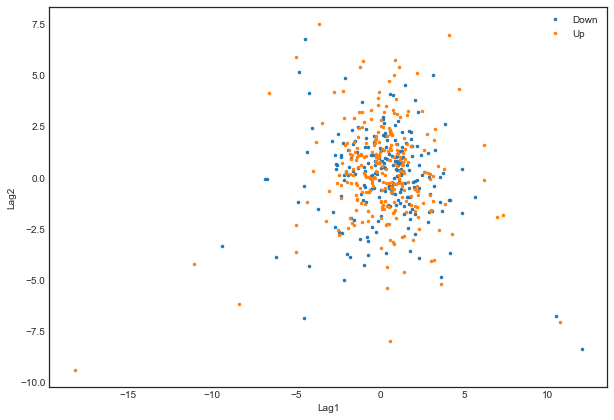

In [6]:
groups = df.sample(n=500).groupby('Direction')
for name, group in groups:
    plt.plot(group["Lag1"], group["Lag2"], marker='o', linestyle='', markersize=2.5, label=name)
    
plt.xlabel("Lag1")
plt.ylabel("Lag2")

plt.legend()

The above plot tries to visualize the effect of Lag1 and Lag2 on the direction of the stock. There seems to be no clear pattern in this. Perhaps, applying some machine learning algorithms will reveal a pattern here.

<b>(b)</b>

In [20]:
clf = sm.Logit(df['Direction2'], df[['Lag1','Lag2', 'Lag3','Lag4', 'Lag5','Volume']])
result = clf.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.686896
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             Direction2   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1083
Method:                           MLE   Df Model:                            5
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:               9.505e-05
Time:                        22:13:51   Log-Likelihood:                -748.03
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.9996
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag1          -0.0327      0.026     -1.250      0.211      -0.084       0.019
Lag2           0.0682      0.

Lag2 and Volume seem to be the most significant predictors when we fit the model using all of the features. They are both significant when $\alpha = 0.05$.

<b>(c)</b>

In [14]:
# Confusion matrix

def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positive (Actual): ', np.sum(cm[1]))

True Negatives:  54
False Positives:  430
False Negatives:  48
True Positives:  557
Total Positive (Actual):  605


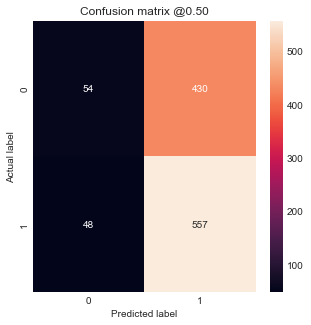

In [15]:
plot_cm(df["Direction2"], clf.predict(df[['Lag1','Lag2', 'Lag3','Lag4', 'Lag5','Volume']]))

The overall fraction of the correct predictions is 611/1089 $\approx$ 0.56165. Most of the mistakes made were false positives, meaning: our model predicted that the stock will go up when the stock actually went down.

<b>(d)</b>

In [16]:
#from sklearn.model_selection import train_test_split
#df_train, df_test = train_test_split(smarket, random_state=1)
df_train = df[df['Year']<2009]
df_test = df[df['Year']>=2009]

In [17]:
logistic = skl_lm.LogisticRegression(solver='newton-cg')
logistic.fit(df_train[['Lag2']],df_train['Direction2'])

LogisticRegression(solver='newton-cg')

True Negatives:  9
False Positives:  34
False Negatives:  5
True Positives:  56
Total Positive (Actual):  61


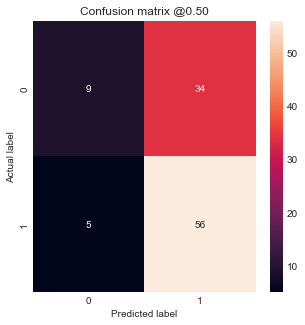

In [18]:
plot_cm(df_test["Direction2"], logistic.predict(df_test[['Lag2']]))

The overall fraction of the correct predictions for the logistic regression model on the test data is 65/104 = 0.625.

<b>(e)</b>

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(df_train[["Lag2"]], df_train["Direction2"]).predict(df_test[["Lag2"]])

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

True Negatives:  9
False Positives:  34
False Negatives:  5
True Positives:  56
Total Positive (Actual):  61


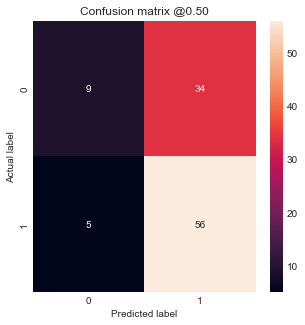

In [20]:
plot_cm(df_test["Direction2"], lda.predict(df_test[['Lag2']]))

The overall fraction of the correct predictions for the LDA model on the test data is 65/104 = 0.625.

<b>(f)</b>

In [21]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(df_train[["Lag2"]], df_train["Direction2"]).predict(df_test[["Lag2"]])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

True Negatives:  0
False Positives:  43
False Negatives:  0
True Positives:  61
Total Positive (Actual):  61


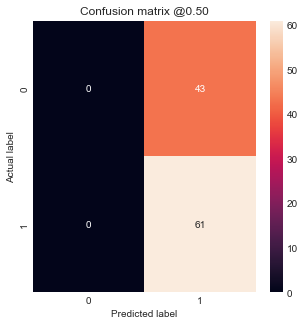

In [22]:
plot_cm(df_test["Direction2"], qda.predict(df_test[['Lag2']]))

The overall fraction of the correct predictions for the QDA model on the test data is 61/104 $\approx$ 0.58654.

<b>(g)</b>

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(df_train[["Lag2"]], df_train["Direction2"]).predict(df_test[["Lag2"]])

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

True Negatives:  22
False Positives:  21
False Negatives:  30
True Positives:  31
Total Positive (Actual):  61


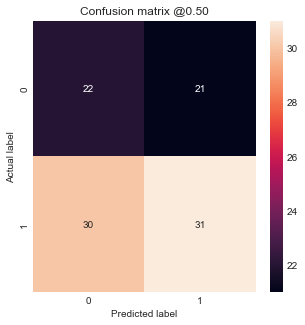

In [24]:
plot_cm(df_test["Direction2"], knn.predict(df_test[['Lag2']]))

The overall fraction of the correct predictions for the KNN model on the test data is 53/104 $\approx$ 0.50962.

<b>(h)</b>

The logistic regression model and the LDA model appear to provide the best results on this data.

<b>(i)</b>

I will create two types of dataframes to train each of the algorithms on. One of the dataframe will consist of all of the given lag features and volume. The other dataframe will include quadratic transformations of all of the features and all interactions of the features. I will use the test accuracy to choose the best model.

In [117]:
x_train = df_train.drop(['Direction', 'Direction2', 'Unnamed: 0', 'Year', 'Today'], axis=1)
y_train = df_train['Direction2']
x_test = df_test.drop(['Direction', 'Direction2', 'Unnamed: 0', 'Year', 'Today'], axis=1)
y_test = df_test['Direction2']

In [124]:
x_train.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume
0,0.816,1.572,-3.936,-0.229,-3.484,0.154976
1,-0.270,0.816,1.572,-3.936,-0.229,0.148574
2,-2.576,-0.270,0.816,1.572,-3.936,0.159837
3,3.514,-2.576,-0.270,0.816,1.572,0.161630
4,0.712,3.514,-2.576,-0.270,0.816,0.153728


In [119]:
all_train = x_train.copy()
for feature in ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']:
    for feature2 in ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']:
        all_train[feature+'_'+feature2] = all_train[feature]*all_train[feature2]
all_train = all_train.T.drop_duplicates().T
all_train.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Lag1_Lag1,Lag1_Lag2,Lag1_Lag3,Lag1_Lag4,...,Lag3_Lag3,Lag3_Lag4,Lag3_Lag5,Lag3_Volume,Lag4_Lag4,Lag4_Lag5,Lag4_Volume,Lag5_Lag5,Lag5_Volume,Volume_Volume
0,0.816,1.572,-3.936,-0.229,-3.484,0.154976,0.665856,1.282752,-3.211776,-0.186864,...,15.492096,0.901344,13.713024,-0.609986,0.052441,0.797836,-0.035490,12.138256,-0.539936,0.024018
1,-0.270,0.816,1.572,-3.936,-0.229,0.148574,0.072900,-0.220320,-0.424440,1.062720,...,2.471184,-6.187392,-0.359988,0.233558,15.492096,0.901344,-0.584787,0.052441,-0.034023,0.022074
2,-2.576,-0.270,0.816,1.572,-3.936,0.159837,6.635776,0.695520,-2.102016,-4.049472,...,0.665856,1.282752,-3.211776,0.130427,2.471184,-6.187392,0.251265,15.492096,-0.629120,0.025548
3,3.514,-2.576,-0.270,0.816,1.572,0.161630,12.348196,-9.052064,-0.948780,2.867424,...,0.072900,-0.220320,-0.424440,-0.043640,0.665856,1.282752,0.131890,2.471184,0.254082,0.026124
4,0.712,3.514,-2.576,-0.270,0.816,0.153728,0.506944,2.501968,-1.834112,-0.192240,...,6.635776,0.695520,-2.102016,-0.396003,0.072900,-0.220320,-0.041507,0.665856,0.125442,0.023632


In [121]:
all_test = x_test.copy()
for feature in ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']:
    for feature2 in ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']:
        all_test[feature+'_'+feature2] = all_test[feature]*all_test[feature2]
all_test = all_test.T.drop_duplicates().T

In [125]:
Log = skl_lm.LogisticRegression(solver='newton-cg')
knn1 = neighbors.KNeighborsClassifier(n_neighbors=1)
knn3 = neighbors.KNeighborsClassifier(n_neighbors=3)
knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)
knn10 = neighbors.KNeighborsClassifier(n_neighbors=10)
QDA = QuadraticDiscriminantAnalysis()
LDA = LinearDiscriminantAnalysis()

In [128]:
Log.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, Log.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, Log.predict(x_test)))

Train accuracy is: 0.5624365482233502
Test accuracy is: 0.46153846153846156


In [129]:
Log.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, Log.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, Log.predict(all_test)))

Train accuracy is: 0.5644670050761421
Test accuracy is: 0.5673076923076923


In [130]:
knn1.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn1.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn1.predict(x_test)))

Train accuracy is: 1.0
Test accuracy is: 0.4807692307692308


In [131]:
knn1.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn1.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn1.predict(all_test)))

Train accuracy is: 1.0
Test accuracy is: 0.49038461538461536


In [132]:
knn3.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn3.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn3.predict(x_test)))

Train accuracy is: 0.732994923857868
Test accuracy is: 0.5096153846153846


In [133]:
knn3.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn3.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn3.predict(all_test)))

Train accuracy is: 0.7472081218274111
Test accuracy is: 0.49038461538461536


In [134]:
knn5.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn5.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn5.predict(x_test)))

Train accuracy is: 0.6934010152284263
Test accuracy is: 0.5


In [135]:
knn5.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn5.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn5.predict(all_test)))

Train accuracy is: 0.6913705583756345
Test accuracy is: 0.5096153846153846


In [136]:
knn10.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn10.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn10.predict(x_test)))

Train accuracy is: 0.6294416243654822
Test accuracy is: 0.5480769230769231


In [137]:
knn10.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn10.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn10.predict(all_test)))

Train accuracy is: 0.6385786802030456
Test accuracy is: 0.5865384615384616


In [138]:
QDA.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, QDA.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, QDA.predict(x_test)))

Train accuracy is: 0.5614213197969543
Test accuracy is: 0.4326923076923077


In [139]:
QDA.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, QDA.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, QDA.predict(all_test)))

Train accuracy is: 0.5786802030456852
Test accuracy is: 0.4423076923076923


In [140]:
LDA.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, LDA.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, LDA.predict(x_test)))

Train accuracy is: 0.5614213197969543
Test accuracy is: 0.46153846153846156


In [141]:
LDA.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, LDA.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, LDA.predict(all_test)))

Train accuracy is: 0.5675126903553299
Test accuracy is: 0.5769230769230769


The KNN with n_neighbors=10 trained on all combinations of features, gave the best test accuracy, which is about 0.5865. For all of the KNN methods tested, as the n_neighbors went up, the accuracy improved. So, I will test higher n_neighbors.

In [142]:
knn15 = neighbors.KNeighborsClassifier(n_neighbors=15)
knn20 = neighbors.KNeighborsClassifier(n_neighbors=20)

In [143]:
knn15.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn15.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn15.predict(x_test)))

Train accuracy is: 0.6192893401015228
Test accuracy is: 0.5576923076923077


In [144]:
knn15.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn15.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn15.predict(all_test)))

Train accuracy is: 0.6233502538071066
Test accuracy is: 0.5480769230769231


In [145]:
knn20.fit(x_train, y_train)
print("Train accuracy is:", accuracy_score(y_train, knn20.predict(x_train)))
print("Test accuracy is:", accuracy_score(y_test, knn20.predict(x_test)))

Train accuracy is: 0.6091370558375635
Test accuracy is: 0.5


In [147]:
knn20.fit(all_train, y_train)
print("Train accuracy is:",accuracy_score(y_train, knn20.predict(all_train)))
print("Test accuracy is:", accuracy_score(y_test, knn20.predict(all_test)))

Train accuracy is: 0.5857868020304569
Test accuracy is: 0.5576923076923077


As we increased the n_neighbors beyond 10, the accuracy did not improve. So, our best model based on test accuracy is the KNN with n_neighbors=10, trained on all combinations of interactions.